In [1]:
#Importando as bibliotecas

import arcpy
from arcpy import env
import os
from arcpy.ia import *
env.overwriteOutput = True

In [2]:
# Diretórios de trabalho
# Diretório GDB
workspace1 = r'E:\Cursos\GeoAI\GeoAI_03\GeoAI_03.gdb'
# Diretório raiz
workspace2 = r'E:\Cursos\GeoAI\GeoAI_03'

In [3]:
# Diretório de Imagens
imagem_dir = r'E:\Cursos\GeoAI\GeoAI_02\Imagens'

# Bandas
b0 = os.path.join(imagem_dir, 'CBERS_4A_WPM_20210727_211_115_L4_BAND0.tif')
b1 = os.path.join(imagem_dir, 'CBERS_4A_WPM_20210727_211_115_L4_BAND1.tif')
b2 = os.path.join(imagem_dir, 'CBERS_4A_WPM_20210727_211_115_L4_BAND2.tif')
b3 = os.path.join(imagem_dir, 'CBERS_4A_WPM_20210727_211_115_L4_BAND3.tif')
b4 = os.path.join(imagem_dir, 'CBERS_4A_WPM_20210727_211_115_L4_BAND4.tif')

# Composição Colorida

In [4]:
# Diratório da composição

composicao_output = os.path.join(workspace2, 'composicao.tif')


In [92]:
# Bandas para composição
composicao = r'{};{};{};{}'.format(b4,b2,b3,b1)

In [73]:
# Composição das bandas
arcpy.management.CompositeBands(in_rasters = composicao,
                                out_raster = composicao_output)

<Result 'E:\\Cursos\\GeoAI\\GeoAI_03\\composicao.tif'>

# Pansharpene

In [5]:
#diratório do arquivo pansharpene
pan_output = os.path.join(workspace2, 'pansharpene.tif')


In [32]:
#Realizar o Pansharnepe

arcpy.ia.Pansharpen(b0, composicao_output,True,'Gram-Schmidt').save(pan_output)

<Result 'E:\\Cursos\\GeoAI\\GeoAI_03\\pansharpene_2.tif'>

# Clip

In [33]:
# Diretório do clip

clip = os.path.join (workspace2, 'clip.tif')
clip_02 = os.path.join (workspace2, 'clip_02.tif')
ROI = os.path.join (workspace1, 'ROI')
ROI_02 = os.path.join (workspace1, 'ROI_02')

In [34]:
arcpy.Clip_management(pan_output, '',
                      clip_02, ROI_02, '0', 'ClippingGeometry',
                      'MAINTAIN_EXTENT')

<Result 'E:\\Cursos\\GeoAI\\GeoAI_03\\clip_02.tif'>

# Classificando

In [37]:
# Diretório das amostras e do esquema
amostra_pixel = os.path.join(workspace2, 'amostras_GeoAI.shp')
output_ecd = os.path.join(workspace2, "Class_GeoAI.ecd")

In [39]:
# Treino e classificação por SVM
arcpy.ia.TrainSupportVectorMachineClassifier(clip, amostra_pixel, output_ecd, '',
                                            20, None, 'Classvalue')

<geoprocessing server result object object at 0x0000027C97186360>

In [40]:
# Diretório de classificação
classificado = os.path.join(workspace2, 'classified_02.tif')

In [41]:
# Classificação das imagens
out_raster_dataset = arcpy.ia.ClassifyRaster(clip_02, output_ecd, ''); out_raster_dataset.save(classificado)

# Transformar raster to polygon

In [9]:
# Diretório dos polígonos
out_poligon = os.path.join(workspace1, 'poligons')
classificada = os.path.join(workspace2, 'classified.tif')

In [38]:
# Raster to Polygon
arcpy.conversion.RasterToPolygon(classificada,
                                out_poligon,
                                'SIMPLIFY',
                                'Classvalue',
                                'SINGLE_OUTER_PART',
                                None)

<Result 'E:\\Cursos\\GeoAI\\GeoAI_03\\GeoAI_03.gdb\\poligons'>

# Imagem para Classificar

In [10]:
# Imagem para classificar
input_imagem = os.path.join(workspace2, 'clip.tif')
out_amostras = os.path.join(workspace2, 'amostra')

In [40]:
arcpy.ia.ExportTrainingDataForDeepLearning(input_imagem,
                                          out_amostras,
                                          out_poligon,
                                          'TIFF',
                                          256,256,128,128,
                                          'ONLY_TILES_WITH_FEATURES',
                                          'Classified_Tiles',
                                          0, 'gridcode',
                                          0, None, 0,
                                          'MAP_SPACE',
                                          'PROCESS_AS_MOSAICKED_IMAGE',
                                          'NO_BLACKEN',
                                          'FIXED_SIZE',
                                          None)

<geoprocessing server result object object at 0x000001D396E53CF0>

# Treinando o Modelo

In [11]:
from arcgis.learn import *

In [12]:
# Ler as amostras
data = prepare_data(path = out_amostras,
                   batch_size=3,
                   dataset_type='Classified_Tiles',
                   chip_size= 256)

In [13]:
# Configurando o modelos
model = UnetClassifier(data, backbone = 'resnet34')

In [14]:
# Learning Rate
lr = 0.001

In [27]:
model.fit(40, lr=lr)

epoch     train_loss  valid_loss  accuracy  dice      time    
0         0.153856    0.153205    0.936365  0.933817  03:35     
1         0.154537    0.155681    0.935252  0.932658  03:59     
2         0.169605    0.158260    0.935041  0.932464  03:57     
3         0.176105    0.158197    0.933702  0.930944  03:47     
4         0.169772    0.157438    0.935085  0.932495  03:56     
5         0.171873    0.158027    0.934104  0.931386  03:54     
6         0.184563    0.176526    0.926988  0.923800  04:05     
7         0.218708    0.170514    0.931315  0.928299  04:10     
8         0.211598    0.176108    0.926568  0.923234  04:04     
9         0.209962    0.173488    0.928935  0.925332  04:02     
10        0.202616    0.180639    0.928592  0.925936  03:52     
11        0.202029    0.187863    0.924113  0.921615  04:01     
12        0.205149    0.191742    0.920378  0.916461  03:44     
13        0.195440    0.171508    0.930861  0.928005  03:55     
14        0.181730    0.171

In [28]:
metrics = model.per_class_metrics()

In [29]:
metrics

,NoData,10,20,30,40
precision,0.997760,0.986262,0.897396,0.868006,0.959973
recall,0.998850,0.990146,0.911548,0.846435,0.965373
f1,0.998305,0.988200,0.904417,0.857085,0.962665


In [30]:
model.mIOU()

{'0': 0.449431757957354, '10': 0.7952218211351475, '20': 0.7184042853807602, '30': 0.7399964707195974, '40': 0.9223251897070149}

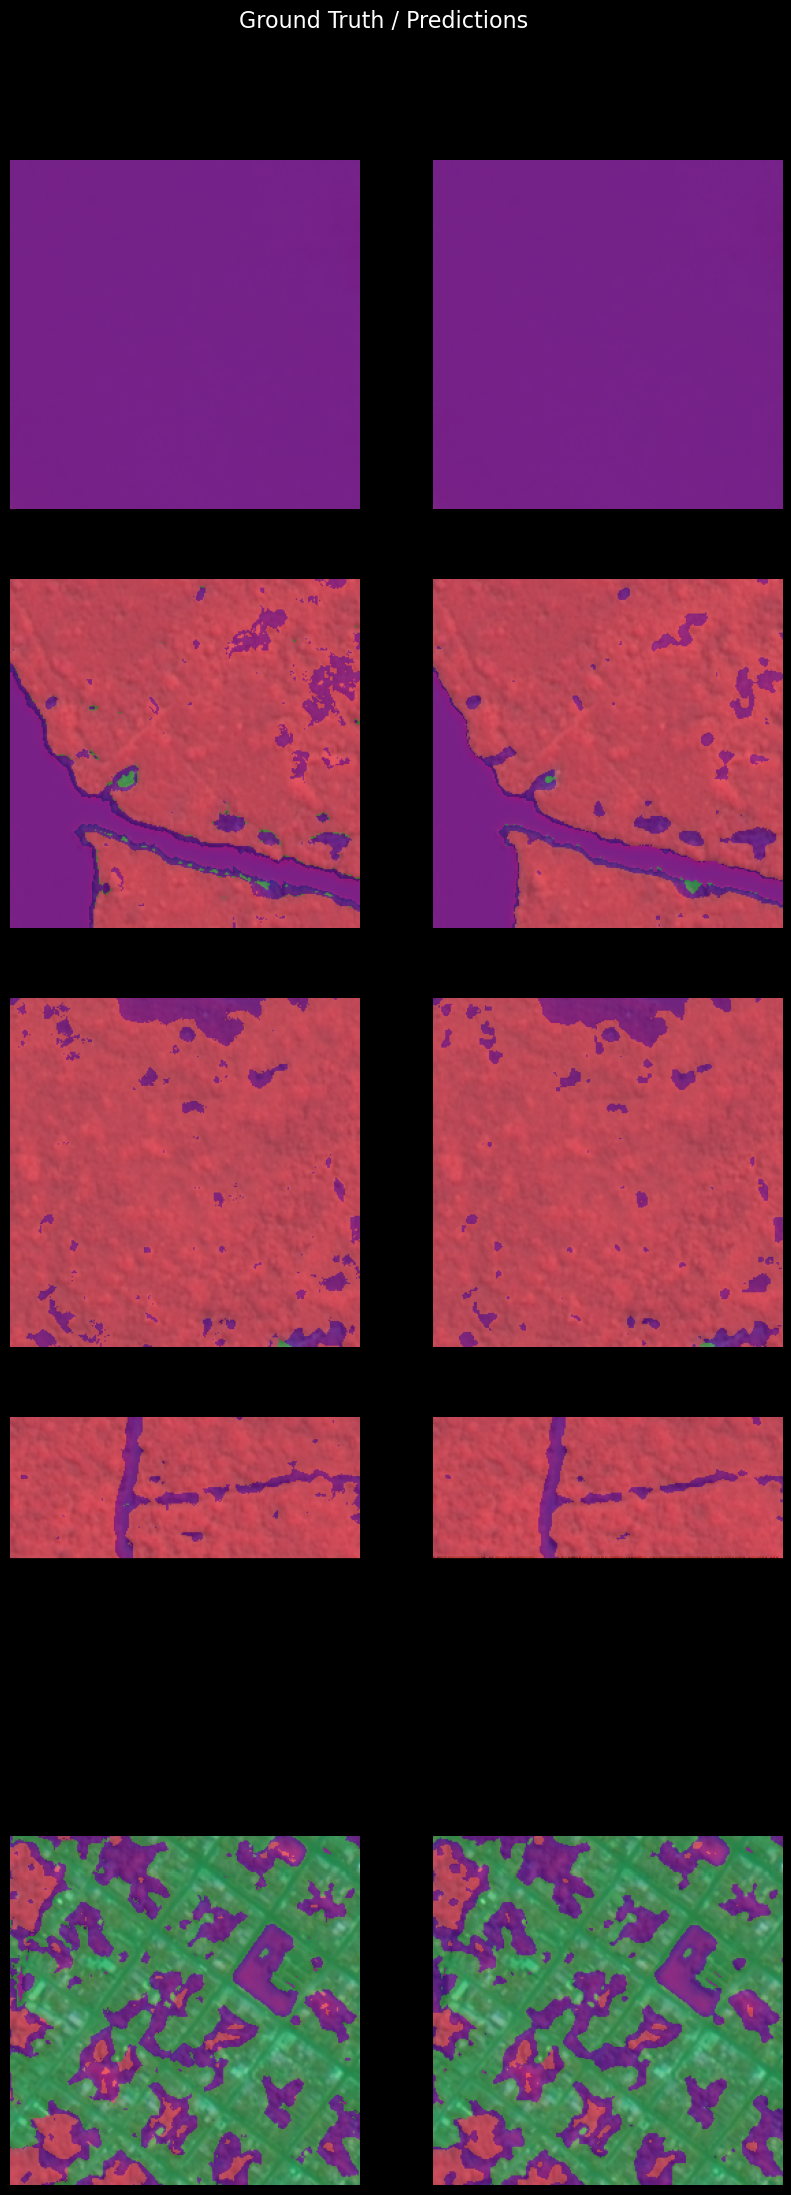

In [31]:
model.show_results()

In [32]:
# Salvar o modelo
model.save('model_UNET')

Computing model metrics...


WindowsPath('E:/Cursos/GeoAI/GeoAI_03/amostra/models/model_UNET')

# Classificando uma nova Imagem

In [47]:
# Configuração de classificação
nova_imagem = os.path.join (workspace2, 'clip_02.tif')
modelo = os.path.join (workspace2, 'amostra\models\model_UNET\model_UNET.dlpk')

parametros = 'padding 56; batch_size 4; predict_background True; tile_size 256'

In [48]:
# Diretório de classificação

out_new_classified = os.path.join(workspace1, 'imagem_classify')

In [49]:
with arcpy.EnvManager (processorType='GPU'):
    out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning(nova_imagem,
                                                                    modelo,
                                                                    parametros,
                                                                    'PROCESS_AS_MOSAICKED_IMAGE',
                                                                    None); out_classified_raster.save(out_new_classified)